# Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")


Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
new_path = config["NEW_DATA_PATH"]
print(f'New data path set to: {new_path}')

New data path set to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project


# Config

In [32]:
from models.utils.config_manager import initialise_config

initialise_config(folder_name="model-inspection-2", verbose=1)


Folder I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection-2 already exists. No changes made.


In [33]:
# or load existing config
from models.utils.config_manager import load_configs, print_config

loaded_config = load_configs(folder_name="model-inspection-2", config_suffix="CuratedModel1")
print_config(loaded_config)

notebook: 
  version: CuratedModel1
  name: model-inspection-2
  compatible_notebooks: ['model-inspection-2']
  desc: CuratedModel1 - Sungyoung's example model designed by hand, captured algorithmically

exp: 
  spec: 
    n_layers: 2
    n_cascades: 3
    n_regs: 0
    basal_activation: True
    custom_regulations: [['R1', 'R2', 'up'], ['R3', 'I1_2', 'up'], ['I1_1', 'I2_2', 'up'], ['I1_2', 'I2_1', 'down'], ['I1_2', 'I2_3', 'down'], ['I1_3', 'I2_2', 'up'], ['I2_1', 'R1', 'down'], ['I2_3', 'R3', 'up']]
    gen_seed: 42
    drug: 
      name: D
      start: 500
      dose: 500
      regulations: [['R1', 'down']]
      target_all: False
  parameter_generation: 
    ic_range: [200, 1000]
    param_range: [0.1, 10]
    param_mul_range: [0.99, 1.01]
  simulation: 
    start: 0
    stop: 1000
    step: 100


# Run

In [34]:
from models.Specs.ModelSpec4 import ModelSpec4

notebook_config = loaded_config["notebook"]
config_name = notebook_config['version']
exp_config = loaded_config["exp"]
spec_config = exp_config['spec']
n_layers = spec_config['n_layers']
new_spec = ModelSpec4(num_intermediate_layers=n_layers)


In [35]:
from models.Specs.Drug import Drug

drug_config = spec_config['drug']
drug_name = drug_config['name']
drug_start = drug_config['start']
drug_dose = drug_config['dose']
drug_regulations = drug_config['regulations']


n_cascades = spec_config["n_cascades"]
n_regs = spec_config["n_regs"]
seed = spec_config["gen_seed"]

for regulation in spec_config["custom_regulations"]:
    new_spec.add_regulation(*regulation)

new_drug = Drug(name=drug_name, start_time=drug_start, default_value=drug_dose)

# check if target_all exists in drug_config, if not set to False
drug_target_all = drug_config.get('target_all', False)

if drug_target_all:
    # If the drug targets all receptors, we don't need to add specific regulations
    for n in range(n_cascades):
        target = f'R{n+1}' # assuming receptors are named R1, R2, ..., Rn
        new_drug.add_regulation(target, 'down') # assuming the type is 'down' for all
else: 
    for regs in drug_regulations:
        target, type = regs[0], regs[1]
        new_drug.add_regulation(target, type)

new_spec.generate_specifications(n_cascades, n_regs, seed)
new_spec.add_drug(new_drug)

In [36]:
param_gen_config = exp_config['parameter_generation']
basal_activation = spec_config["basal_activation"]
specie_range = param_gen_config['ic_range']
param_range = param_gen_config['param_range']
param_mul_range = param_gen_config['param_mul_range']
builder = new_spec.generate_network(
    config_name,
    specie_range,
    param_range,
    param_mul_range,
    seed,
    receptor_basal_activation=basal_activation,
)


In [37]:
from models.utils.config_manager import save_data

antimony_txt = builder.get_antimony_model()
print(antimony_txt)
# save the model to txt file 
save_data(notebook_config, antimony_txt, data_name="antimony_model", data_format="txt", verbose=1)

model CuratedModel1

J0: R1a -> R1; Vmax_J0*R1a/(Km_J0 + R1a)
J1: R1 -> R1a; Kc_J1*R1/(Km_J1 + R1)/(1 + I2_1a/Ki0_J1 + D/Ki1_J1)
J2: R2a -> R2; Vmax_J2*R2a/(Km_J2 + R2a)
J3: R2 -> R2a; (Kc_J3+Kc0_J3*R1a)*R2/(Km_J3 + R2)
J4: R3a -> R3; Vmax_J4*R3a/(Km_J4 + R3a)
J5: R3 -> R3a; (Kc_J5+Kc0_J5*I2_3a)*R3/(Km_J5 + R3)
J6: I1_1a -> I1_1; Vmax_J6*I1_1a/(Km_J6 + I1_1a)
J7: I1_1 -> I1_1a; (Kc0_J7*R1a)*I1_1/(Km_J7 + I1_1)
J8: I1_2a -> I1_2; Vmax_J8*I1_2a/(Km_J8 + I1_2a)
J9: I1_2 -> I1_2a; (Kc0_J9*R3a+Kc1_J9*R2a)*I1_2/(Km_J9 + I1_2)
J10: I1_3a -> I1_3; Vmax_J10*I1_3a/(Km_J10 + I1_3a)
J11: I1_3 -> I1_3a; (Kc0_J11*R3a)*I1_3/(Km_J11 + I1_3)
J12: I2_1a -> I2_1; Vmax_J12*I2_1a/(Km_J12 + I2_1a)
J13: I2_1 -> I2_1a; (Kc0_J13*I1_1a)*I2_1/(Km_J13 + I2_1)/(1 + I1_2a/Ki0_J13)
J14: I2_2a -> I2_2; Vmax_J14*I2_2a/(Km_J14 + I2_2a)
J15: I2_2 -> I2_2a; (Kc0_J15*I1_1a+Kc1_J15*I1_3a+Kc2_J15*I1_2a)*I2_2/(Km_J15 + I2_2)
J16: I2_3a -> I2_3; Vmax_J16*I2_3a/(Km_J16 + I2_3a)
J17: I2_3 -> I2_3a; (Kc0_J17*I1_3a)*I2_3/(Km_J17 

In [38]:
from models.Solver.RoadrunnerSolver import RoadrunnerSolver
from models.utils.config_manager import save_data
sim_config = exp_config['simulation']
sim_start = sim_config['start']
sim_stop = sim_config['stop']
sim_step = sim_config['step']
solver = RoadrunnerSolver()
solver.compile(builder.get_sbml_model())
res = solver.simulate(sim_start, sim_stop, sim_step)

save_data(notebook_config, res, "simulation_data")
save_data(notebook_config, res, "simulation_data", "csv", verbose=1)

Data saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection-2\data\CuratedModel1_simulation_data.csv


Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection-2\figures\CuratedModel1_simulation_plot.png


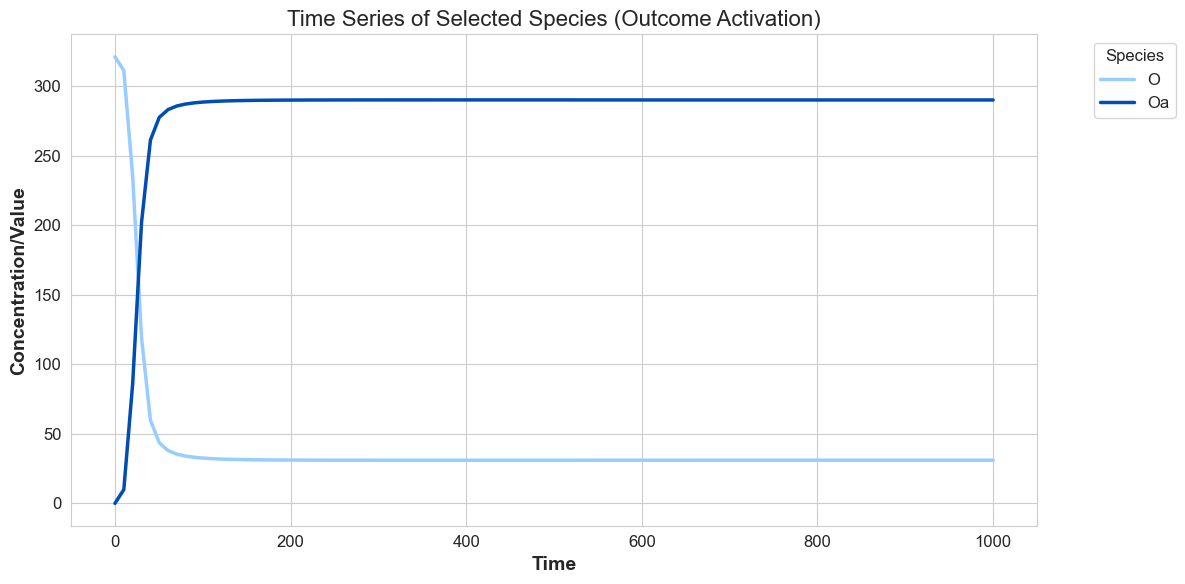

In [39]:
from visual.simulation import visualise_simulation
from models.utils.config_manager import save_figure

figure = visualise_simulation(res, activated_only=True, outcome_activation=True, show_legend=True)
save_figure(notebook_config, figure, "simulation_plot", "png", verbose=1, dpi=300)

Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection-2\figures\CuratedModel1_network_topology.png


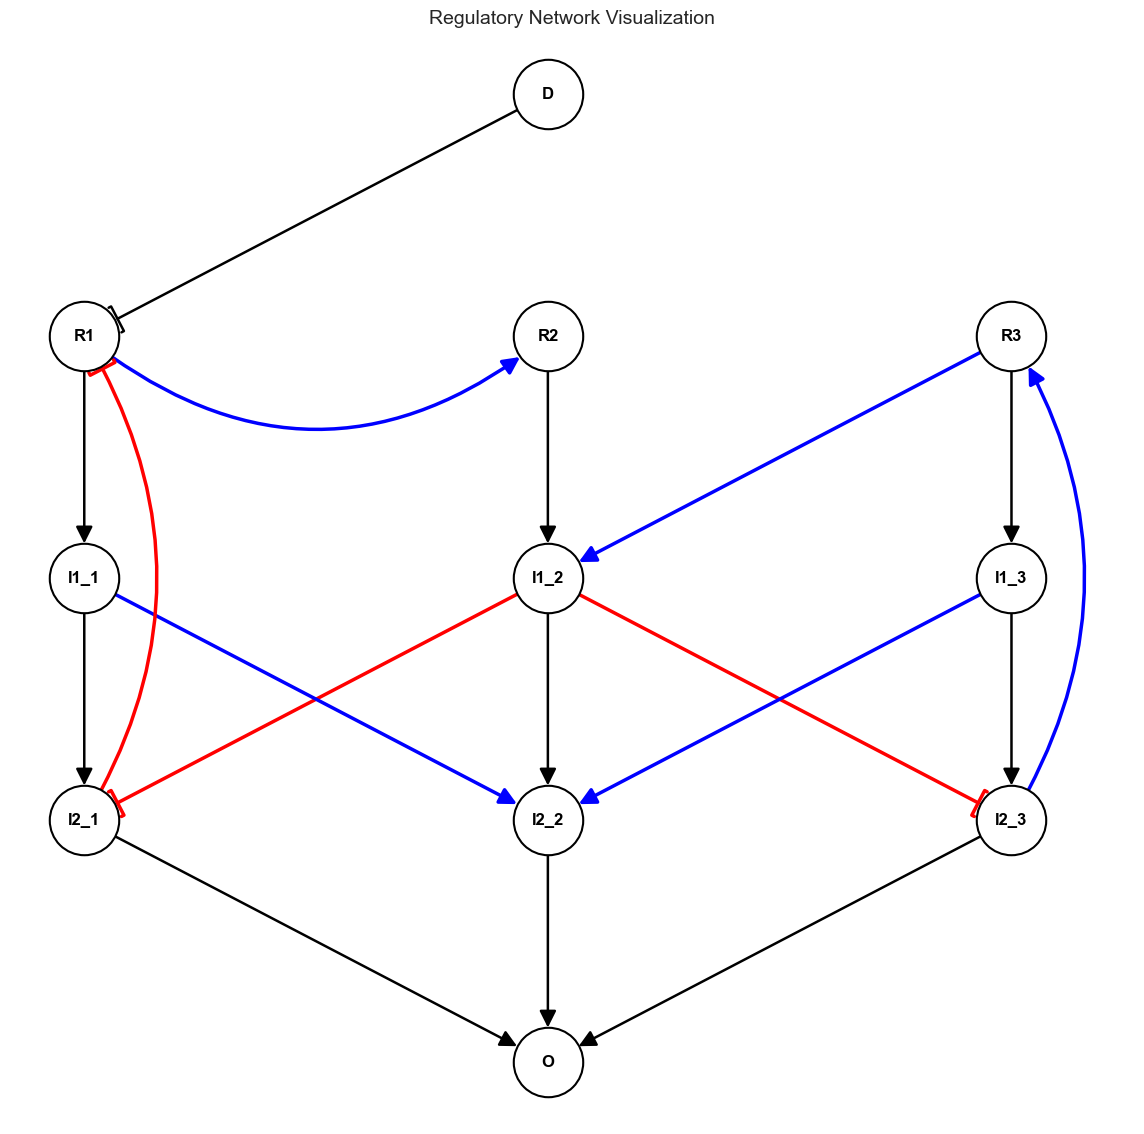

In [40]:
from visual.network_topology import visualise_network_2, create_layers

# num_intermediate_layers=2, num_cascades=3, drugs=['D']

layers = create_layers(n_layers, n_cascades, [drug_name])
regulations = new_spec.get_regulations()
feedback_regulations = new_spec.get_feedback_regulations()
figure = visualise_network_2(layers, regulations, feedback_regulations=feedback_regulations)
save_figure(notebook_config, figure, "network_topology", "png", verbose=1, dpi=300)